# Introduction

My final project is a comparison between 6 CNN models built with different optimizers and learning rates. I used a dataset from https://www.kaggle.com/c/dogs-vs-cats/code which is a competition for building a model that can determine the difference between cats and dogs. The training dataset consists of 25,000 images split equally between cats and dogs.  There are then 12,500 images in the testing dataset. The goal in this project is to determine which optimizer performs the best, and also to see what kind of impact the learning rate parameter might have.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import zipfile
from PIL import Image
from IPython.display import display

2024-03-05 08:31:56.403759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 08:31:56.403851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 08:31:56.520296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Analysis & EDA

This dataset comes to us in zip files, so it must first be unzipped. The second step is labeling the data, as each file is labeled either cat.jpg or dog.jpg we can easily create a column that holds the information for whether the training picture is a cat or a dog. The last part of my EDA was to determine if the images were the same size (and also to get a cute picture). This dataset is relatively clean as it is just pictures of cats and dogs so there's no reason to do further EDA at this point.

In [2]:
working_dir = "/kaggle/working"
training_dir_zip = "/kaggle/input/dogs-vs-cats/train.zip"
testing_dir_zip = "/kaggle/input/dogs-vs-cats/test1.zip"

os.makedirs(working_dir, exist_ok=True)

with zipfile.ZipFile(training_dir_zip, 'r') as train_zip:
    train_zip.extractall(working_dir)
    
with zipfile.ZipFile(testing_dir_zip, 'r') as testing_zip:
    testing_zip.extractall(working_dir)
    
training_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test1"

In [3]:
train_images = os.listdir(training_dir)
test_images = os.listdir(test_dir)

In [4]:
print('No. of Training files: ',len(train_images))
print('No. of Test files: ',len(test_images))

No. of Training files:  25000
No. of Test files:  12500


In [5]:
pets=list()
img_paths=list()
for file_name in train_images:
    pet=file_name.split(".")[0]
    img_path=os.path.join(training_dir, file_name)
    img_paths.append(img_path)
    pets.append(pet)

dataset=pd.DataFrame()
dataset['img']=img_paths
dataset['pet']=pets

In [6]:
dataset.head()

,img,pet
0,/kaggle/working/train/cat.354.jpg,cat
1,/kaggle/working/train/cat.2146.jpg,cat
2,/kaggle/working/train/cat.10762.jpg,cat
3,/kaggle/working/train/cat.3994.jpg,cat
4,/kaggle/working/train/cat.274.jpg,cat


In [7]:
petcount=dataset['pet'].value_counts()
print("Number of dogs : {}".format(petcount['dog']))
print("Number of cats : {}".format(petcount['cat']))

Number of dogs : 12500
Number of cats : 12500


In [8]:
train, validation = train_test_split(dataset, test_size=0.2, random_state=17)

print(len(train))
print(len(validation))

20000
5000


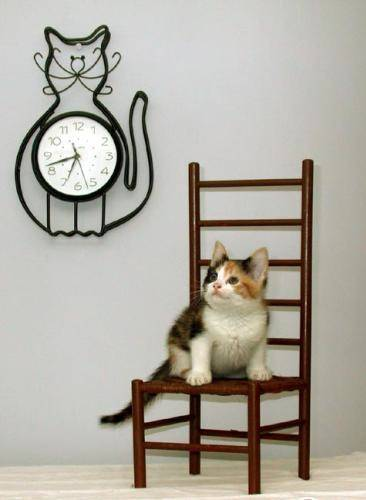

Images have different sizes


In [9]:
images = os.listdir(training_dir)
prev = Image.open(os.path.join(training_dir, images[0]))

display(prev)

for image in images[1:]:
    current = Image.open(os.path.join(training_dir, image))
    if prev.size != current.size:
        print('Images have different sizes')
        break
    prev = current   

# Generators

The generators are relatively simple. I picked parameters essentially randomly to try to make a simple model for future comparisons, a couple important things are the target size at 256x256 and the batch size being set to 200. This did take some trial and error to come up with a reasonable size so the models would not take too long when attempting to fit them. 

In [10]:
train_idg = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_idg = ImageDataGenerator(rescale=1/255)

In [11]:
train_gen = train_idg.flow_from_dataframe(
    dataframe = train,
    x_col="img",
    y_col="pet",
    target_size=(256, 256),
    batch_size=200,
    class_mode='binary'
)

val_gen = val_idg.flow_from_dataframe(
    dataframe = validation,
    x_col="img",
    y_col="pet",
    target_size=(256, 256),
    batch_size=200,
    class_mode='binary'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
print(len(train_gen))
print(len(val_gen))

100
25


# Building the Model

Similar to the generators this is a relatively simple CNN model, using 3 sets of 2 conv2D layers with a 3x3 kernal size and a leaky relu activation function. The input shape has to be 256x256 to match what the generators are producing. The dropout layers were added to prevent overfitting, and unfortunately due to the massive amount of amount of time it takes to run 6 CNN models I had to lower the epochs to 20 instead of 30. In my initial runs at 30 epochs some of the models did overfit with lower dropout, so it's possible these are a bit high at 20 epochs. I then have the flatten layer and 3 Dense layers before the final dense layer activating with the sigmoid function to generate the classification

In [13]:
model = Sequential([
    
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 17,075,745 (65.14 MB)

 Trainable params: 17,075,233 (65.14 MB)

 Non-trainable params: 512 (2.00 KB)

# Optimizers and Learning Rate

I chose to use the Adam, AdamW, and Lion optimizers in the keras.optimizers package, and I ran each optimizer with a learning rate of 0.001 and 0.0001 respectively. As stated previously the initial plan was to run 30 epochs, but due to modeling constraints (ran out of gpu use time) I had to fit the models with 20 epochs per model instead. The results and code are all shown below, and each model has a graph showing the train loss, validation loss, train accuracy, and validation accuracy.

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
train_hist=model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-05 08:32:58.652141: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[200,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[200,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-05 08:33:00.546430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 3.71278, e

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5581 - loss: 0.7564

W0000 00:00:1709627926.343787      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.5582 - loss: 0.7560 - val_accuracy: 0.6002 - val_loss: 0.6606
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.6175 - loss: 0.6583 - val_accuracy: 0.5278 - val_loss: 0.7721
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.6636 - loss: 0.6121 - val_accuracy: 0.5058 - val_loss: 1.0427
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.7006 - loss: 0.5751 - val_accuracy: 0.6416 - val_loss: 0.7075
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.7138 - loss: 0.5669 - val_accuracy: 0.7578 - val_loss: 0.4941
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.7521 - loss: 0.5157 - val_accuracy: 0.7800 - val_loss: 0.4693
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.7634 - loss: 0.5026 - val_accuracy: 0.7868 - val_loss: 0.5011
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.7785 - loss: 0.4731 - val_accuracy: 0.720

In [17]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validation Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validation Accuracy"]=modelHistory.history['val_accuracy']
  
    history.plot(figsize=(12,8))
    plt.title(" Convulutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

Train Accuracy:0.885
Test Accuracy:0.853


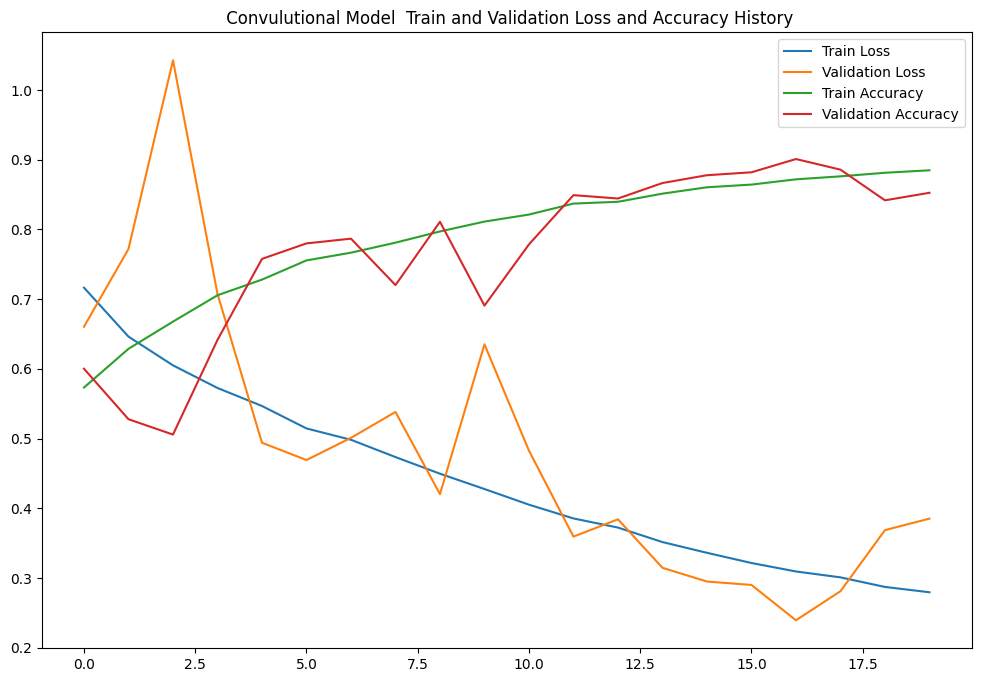

In [18]:
print("Train Accuracy:{:.3f}".format(train_hist.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(train_hist.history['val_accuracy'][-1]))
show_model_history(modelHistory=train_hist, model_name="")

In [19]:
model1 = Sequential([
    
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
opt1 = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(loss='binary_crossentropy', optimizer=opt1, metrics=['accuracy'])

In [21]:
train_hist1=model1.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen
    )

Epoch 1/20


W0000 00:00:1709633445.323260      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5384 - loss: 0.8717

W0000 00:00:1709633702.809520      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.5386 - loss: 0.8710 - val_accuracy: 0.4940 - val_loss: 0.7413
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.5944 - loss: 0.7134 - val_accuracy: 0.4940 - val_loss: 0.7715
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.6079 - loss: 0.6840 - val_accuracy: 0.4940 - val_loss: 0.7732
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.6273 - loss: 0.6455 - val_accuracy: 0.4982 - val_loss: 0.7801
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.6473 - loss: 0.6254 - val_accuracy: 0.5330 - val_loss: 0.7312
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.6552 - loss: 0.6185 - val_accuracy: 0.5586 - val_loss: 0.7313
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6697 - loss: 0.6025 - val_accuracy: 0.5562 - val_loss: 0.7499
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6781 - loss: 0.5939 - val_accuracy: 0.553

Train Accuracy:0.772
Test Accuracy:0.652


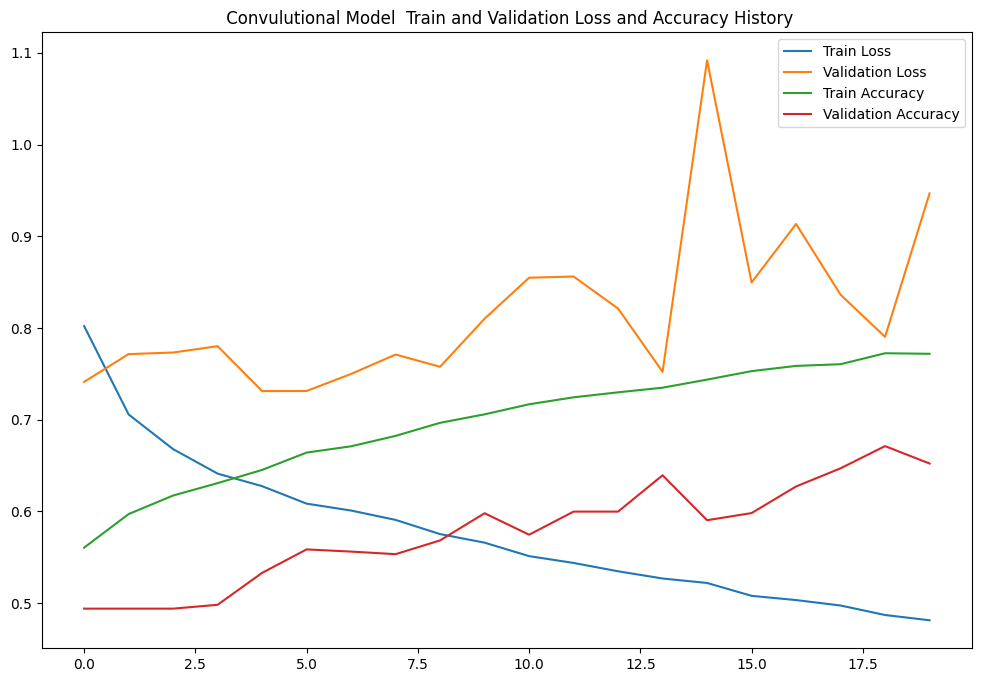

In [22]:
print("Train Accuracy:{:.3f}".format(train_hist1.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(train_hist1.history['val_accuracy'][-1]))
show_model_history(modelHistory=train_hist1, model_name="")

In [23]:
model2 = Sequential([
    
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
opt2 = tf.keras.optimizers.AdamW(learning_rate = 0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])

In [25]:
train_hist2=model2.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen
    )

Epoch 1/20


W0000 00:00:1709639180.153593      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5486 - loss: 0.7774

W0000 00:00:1709639430.221509      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.5487 - loss: 0.7769 - val_accuracy: 0.5060 - val_loss: 0.6820
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.5726 - loss: 0.6734 - val_accuracy: 0.6060 - val_loss: 0.6757
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.6179 - loss: 0.6402 - val_accuracy: 0.5074 - val_loss: 0.6874
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.6494 - loss: 0.6205 - val_accuracy: 0.6240 - val_loss: 0.6315
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.6791 - loss: 0.5946 - val_accuracy: 0.6930 - val_loss: 0.5777
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.6929 - loss: 0.5818 - val_accuracy: 0.7462 - val_loss: 0.5249
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.7095 - loss: 0.5612 - val_accuracy: 0.6916 - val_loss: 0.5639
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.7334 - loss: 0.5305 - val_accuracy: 0.716

Train Accuracy:0.881
Test Accuracy:0.878


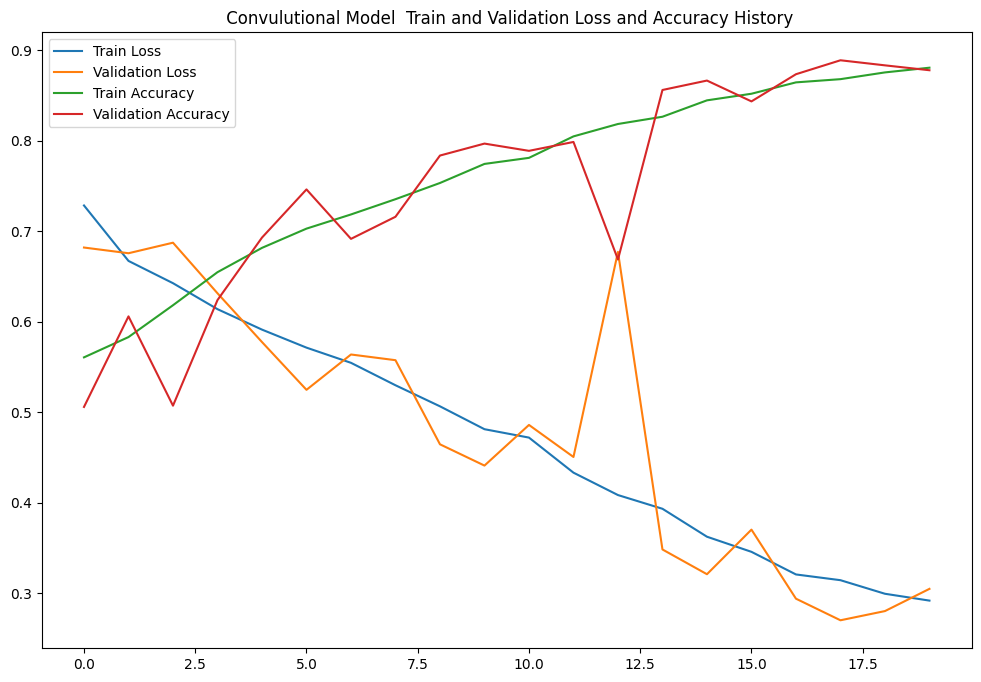

In [26]:
print("Train Accuracy:{:.3f}".format(train_hist2.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(train_hist2.history['val_accuracy'][-1]))
show_model_history(modelHistory=train_hist2, model_name="")

In [27]:
model3 = Sequential([
    
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [28]:
opt3 = tf.keras.optimizers.AdamW(learning_rate = 0.0001)
model3.compile(loss='binary_crossentropy', optimizer=opt3, metrics=['accuracy'])

In [29]:
train_hist3=model3.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen
    )

Epoch 1/20


W0000 00:00:1709644906.139614      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5226 - loss: 0.8211

W0000 00:00:1709645155.167551      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.5228 - loss: 0.8207 - val_accuracy: 0.4940 - val_loss: 0.7465
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.5794 - loss: 0.7166 - val_accuracy: 0.4940 - val_loss: 0.8098
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.5950 - loss: 0.6810 - val_accuracy: 0.4974 - val_loss: 0.7912
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.6010 - loss: 0.6713 - val_accuracy: 0.5434 - val_loss: 0.7912
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.6271 - loss: 0.6426 - val_accuracy: 0.5566 - val_loss: 0.8853
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.6274 - loss: 0.6408 - val_accuracy: 0.5954 - val_loss: 0.7638
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6485 - loss: 0.6277 - val_accuracy: 0.5932 - val_loss: 0.9426
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.6493 - loss: 0.6194 - val_accuracy: 0.621

Train Accuracy:0.761
Test Accuracy:0.699


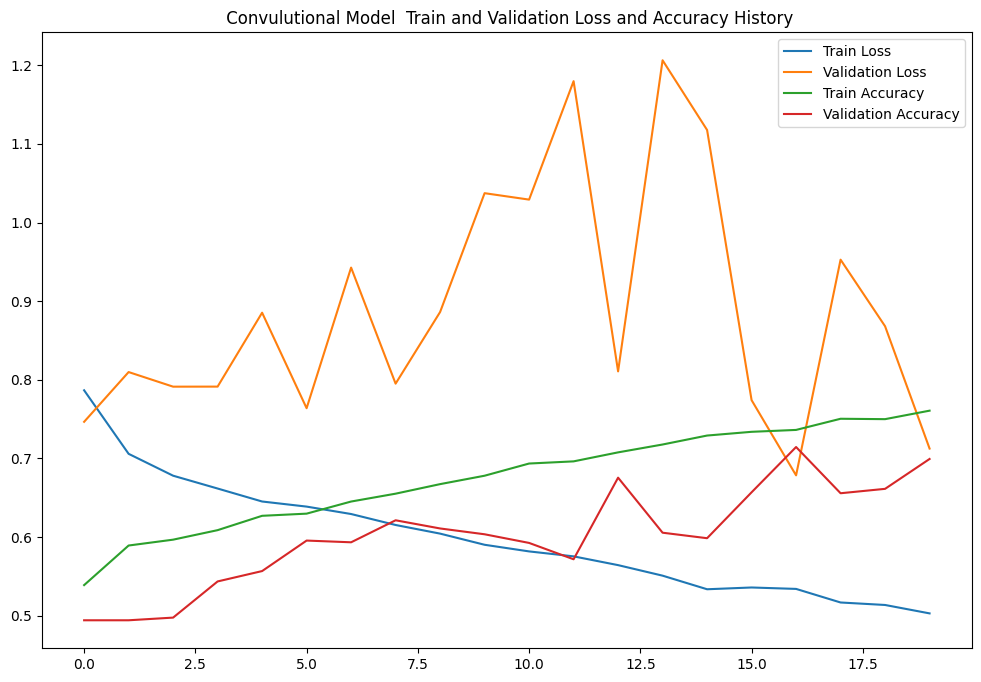

In [30]:
print("Train Accuracy:{:.3f}".format(train_hist3.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(train_hist3.history['val_accuracy'][-1]))
show_model_history(modelHistory=train_hist3, model_name="")

In [31]:
model4 = Sequential([
    
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
opt4 = tf.keras.optimizers.Lion(learning_rate = 0.001)
model4.compile(loss='binary_crossentropy', optimizer=opt4, metrics=['accuracy'])

In [33]:
train_hist4=model4.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen
    )

Epoch 1/20


W0000 00:00:1709650656.997899      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5277 - loss: 0.7751

W0000 00:00:1709650905.011895      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.5278 - loss: 0.7747 - val_accuracy: 0.5472 - val_loss: 3.6700
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.5740 - loss: 0.6761 - val_accuracy: 0.5742 - val_loss: 1.9912
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6135 - loss: 0.6514 - val_accuracy: 0.5832 - val_loss: 1.6712
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.6293 - loss: 0.6390 - val_accuracy: 0.5758 - val_loss: 0.8158
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.6396 - loss: 0.6230 - val_accuracy: 0.6138 - val_loss: 0.9297
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.6757 - loss: 0.5975 - val_accuracy: 0.6254 - val_loss: 0.6584
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.7005 - loss: 0.5677 - val_accuracy: 0.6422 - val_loss: 0.6436
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.7147 - loss: 0.5465 - val_accuracy: 0.759

Train Accuracy:0.836
Test Accuracy:0.806


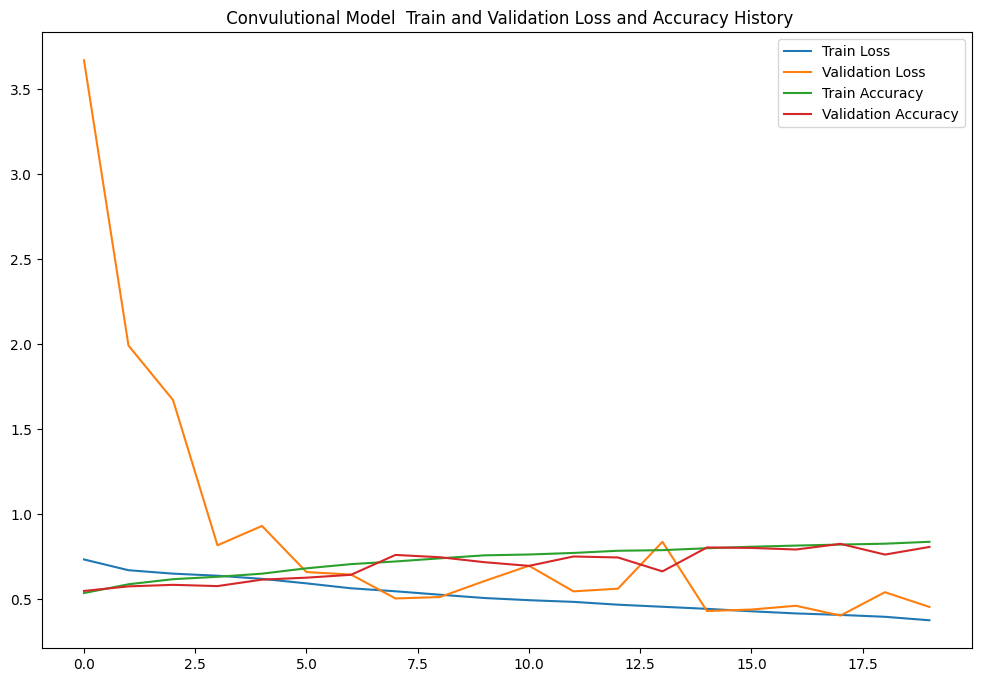

In [34]:
print("Train Accuracy:{:.3f}".format(train_hist4.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(train_hist4.history['val_accuracy'][-1]))
show_model_history(modelHistory=train_hist4, model_name="")

In [35]:
model5 = Sequential([
    
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same', input_shape=(256, 256, 3)),
    Conv2D(32, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'leaky_relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [36]:
opt5 = tf.keras.optimizers.Lion(learning_rate = 0.0001)
model5.compile(loss='binary_crossentropy', optimizer=opt5, metrics=['accuracy'])

In [37]:
train_hist5=model5.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen
    )

Epoch 1/20


W0000 00:00:1709656343.062828      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5375 - loss: 0.8218

W0000 00:00:1709656588.703536      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.5378 - loss: 0.8211 - val_accuracy: 0.4966 - val_loss: 0.6956
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.5850 - loss: 0.6792 - val_accuracy: 0.5408 - val_loss: 0.7427
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.6056 - loss: 0.6551 - val_accuracy: 0.5654 - val_loss: 0.6856
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.6484 - loss: 0.6199 - val_accuracy: 0.6450 - val_loss: 0.6387
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.6791 - loss: 0.5920 - val_accuracy: 0.6476 - val_loss: 0.6935
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7010 - loss: 0.5668 - val_accuracy: 0.5698 - val_loss: 0.9140
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7173 - loss: 0.5519 - val_accuracy: 0.6566 - val_loss: 0.7490
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7263 - loss: 0.5403 - val_accuracy: 0.763

Train Accuracy:0.854
Test Accuracy:0.847


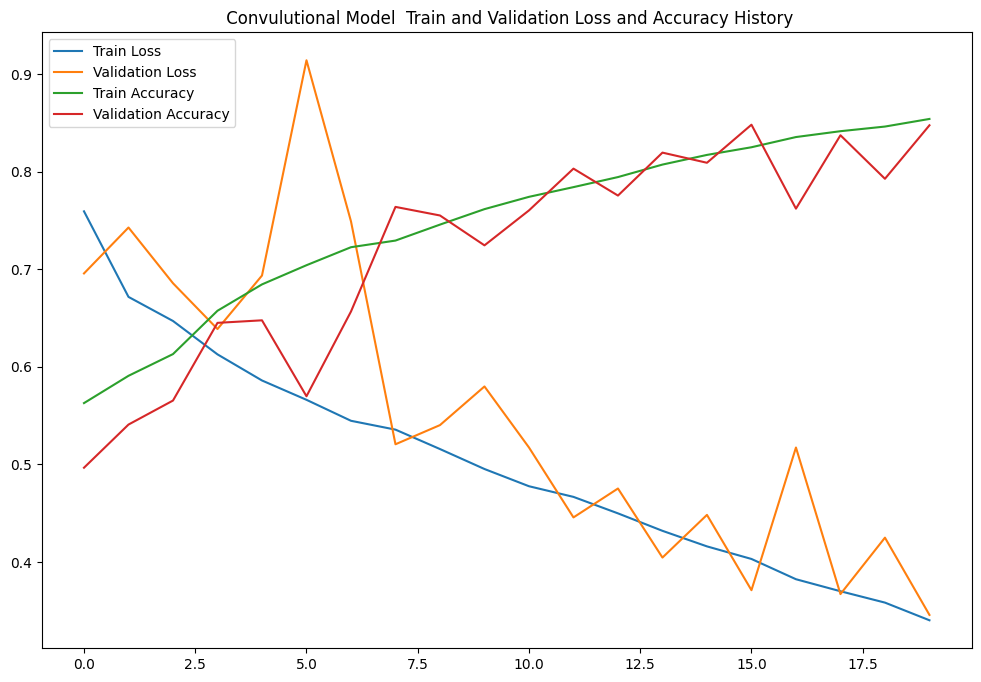

In [38]:
print("Train Accuracy:{:.3f}".format(train_hist5.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(train_hist5.history['val_accuracy'][-1]))
show_model_history(modelHistory=train_hist5, model_name="")

# Results

Using test accuracy the model ranks are as follows:
- AdamW lr 0.001 w/ 0.878 validation accuracy
- Adam lr 0.001 w/ 0.853 validation accuracy
- Lion lr 0.0001 w/0.847 validation accuracy
- Lion lr 0.001 w/ 0.806 validation accuracy
- AdamW lr 0.0001 w/ 0.699 validation accuracy
- Adam lr 0.0001 w/0.652 validation accuracy

This is pretty interesting because we can see that learning rate has a significant effect on AdamW and Adam optimizers, but at least for the Lion optimizer learning rate seemed to make little difference. If anything one could argue the higher learning rate performed worse, but due to the epoch limitation mentioned earlier I would caution against that. Fortunately none of the models appear to be suffering from overfitting at the 20 epoch mark, but we can see that there are some drastic spikes in loss even towards the later epochs indicating that the models may not be completely fit. This is especially apparent in the lower learning rate Adam and AdamW model, and I would expect more epochs to fix this issue and possibly improve the validation accuracy.

# Conclusion

Overall, I feel like this project was a great success. I was able to run 6 CNN models with different optimizers and learning rates and see different results between them. It was very interesting to read about different optimizers and also to know that these are just 3 of many. It's also great that the model performed well overall, with the highest validation accuracy being 0.878 which is fairly good. As mentioned previously, I would have wanted to run this with at least 30 epochs, but this notebook alone took 10 hours to run, so I image adding 10 more epochs to each model fit would likely increase the run time by 5-6 hours. Besides this limitation, the models ran as expected and the visualizations also came out very well.